# Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 14.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
import sys
sys.path.append("../../autotalker")

In [2]:
from datetime import datetime

import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scib

from autotalker.benchmarking import compute_benchmarking_metrics

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 35616), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 35620), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 35632), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/c

### 1.2 Define Parameters

In [3]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
spatial_key = "spatial"
random_seed = 0

### 1.3 Run Notebook Setup

In [4]:
sc.set_figure_params(figsize=(6, 6))

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../datasets/srt_data/gold/"
figure_folder_path = f"../figures/method_benchmarking/{dataset}/"

### 1.5 Define Functions

In [7]:
def compute_combined_benchmarking_metrics(model_adata,
                                          model_name,
                                          spatial_model,
                                          run_number_list=list(np.arange(1, 11)),
                                          n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                          cell_type_key="celltype_mapped_refined"):
    benchmarking_dict_list = []
    for run_number, n_neighbors in zip(run_number_list, n_neighbors_list):
        
        # Compute Autotalker metrics
        benchmarking_dict = compute_benchmarking_metrics(adata=model_adata,
                                                         spatial_model=spatial_model,
                                                         latent_key=f"{model_name}_latent_run{run_number}",
                                                         active_gp_names_key=f"{model_name}_active_gp_names_run{run_number}",
                                                         cell_type_key=cell_type_key,
                                                         spatial_key="spatial",
                                                         spatial_knng_key = f"{model_name}_spatial_{n_neighbors}nng",
                                                         latent_knng_key = f"{model_name}_latent_{n_neighbors}nng",
                                                         n_neighbors=n_neighbors)

        # Compute scib metrics
        sc.pp.neighbors(adata=model_adata,
                        use_rep=f"{model_name}_latent_run{run_number}",
                        n_neighbors=15) # default
        scib.me.cluster_optimal_resolution(adata=model_adata,
                                           cluster_key="cluster",
                                           label_key=cell_type_key)
        benchmarking_dict["ari"] = scib.me.ari(model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["clisi"] = scib.me.clisi_graph(adata=model_adata,
                                                         label_key=cell_type_key,
                                                         type_="embed",
                                                         use_rep=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["nmi"] = scib.me.nmi(adata=model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["asw"] = scib.me.silhouette(adata=model_adata,
                                                      label_key=cell_type_key,
                                                      embed=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["isolated_labels_asw"] = scib.me.isolated_labels_asw(adata=model_adata,
                                                                               batch_key="sample",
                                                                               label_key=cell_type_key,
                                                                               embed=f"{model_name}_latent_run{run_number}")
        
        benchmarking_dict["model_name"] = model_name
        benchmarking_dict["run"] = run_number
        benchmarking_dict_list.append(benchmarking_dict)
    return benchmarking_dict_list

## 2. Data

In [8]:
# Load data after running all notebooks in the 'method_benchmarking' folder
adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")

## 3. Method Benchmarking

### 3.1 PCA

- Evaluate PCA of log normalized gene expression.
- Run ```method_benchmarking/pca/pca.ipynb``` before evaluation.

In [9]:
benchmarking_dict_list_pca = compute_combined_benchmarking_metrics(model_adata=adata_pca,
                                                                   model_name="pca",
                                                                   spatial_model=False,
                                                                   run_number_list=[1],
                                                                   n_neighbors_list=[12],
                                                                   cell_type_key="celltype_mapped_refined")

resolution: 0.1, nmi: 0.6695952741187797
resolution: 0.2, nmi: 0.7385439836334321
resolution: 0.3, nmi: 0.7123739081526013
resolution: 0.4, nmi: 0.7077612436556762
resolution: 0.5, nmi: 0.679065216143822
resolution: 0.6, nmi: 0.689482435231807
resolution: 0.7, nmi: 0.6772664116869933
resolution: 0.8, nmi: 0.6699740233005426
resolution: 0.9, nmi: 0.6741417815701275
resolution: 1.0, nmi: 0.6738611900287442
resolution: 1.1, nmi: 0.6715452341100905
resolution: 1.2, nmi: 0.6645002353577019
resolution: 1.3, nmi: 0.6596491788450072
resolution: 1.4, nmi: 0.6656020307195687
resolution: 1.5, nmi: 0.6586871427428685
resolution: 1.6, nmi: 0.6485736922944785
resolution: 1.7, nmi: 0.6530264394856284
resolution: 1.8, nmi: 0.6527707929669109
resolution: 1.9, nmi: 0.6466768902310875
resolution: 2.0, nmi: 0.6482103286156078
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.2
optimal score: 0.7385439836334321
isolated labels: no more than 1 batches per label
Allantois: 0.

In [10]:
del(adata_pca)

### 3.2 scVI

- Evaluate scVI.
- Run ```method_benchmarking/scvi/scvi.ipynb``` before evaluation.

In [11]:
benchmarking_dict_list_scvi = compute_combined_benchmarking_metrics(model_adata=adata_scvi,
                                                                    model_name="scvi",
                                                                    spatial_model=False,
                                                                    run_number_list=list(np.arange(1, 2)),
                                                                    n_neighbors_list=[4],
                                                                    cell_type_key="celltype_mapped_refined")

resolution: 0.1, nmi: 0.6510112755134858
resolution: 0.2, nmi: 0.6907614873560975
resolution: 0.3, nmi: 0.6887016496029861
resolution: 0.4, nmi: 0.6497561698382365
resolution: 0.5, nmi: 0.6714500541419256
resolution: 0.6, nmi: 0.6434150067935084
resolution: 0.7, nmi: 0.6377239649706704
resolution: 0.8, nmi: 0.6581777770337697
resolution: 0.9, nmi: 0.6484701775225603
resolution: 1.0, nmi: 0.63894088043837
resolution: 1.1, nmi: 0.6396198862517618
resolution: 1.2, nmi: 0.6359441530581543
resolution: 1.3, nmi: 0.627887869115528
resolution: 1.4, nmi: 0.6241053306020455
resolution: 1.5, nmi: 0.6290970674247918
resolution: 1.6, nmi: 0.6208974400448526
resolution: 1.7, nmi: 0.6177545246548721
resolution: 1.8, nmi: 0.6199699169778355
resolution: 1.9, nmi: 0.607065641579197
resolution: 2.0, nmi: 0.6144378835869146
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.2
optimal score: 0.6907614873560975
isolated labels: no more than 1 batches per label
Allantois: 0.48

In [12]:
del(adata_scvi)

### 3.3 expiMap

- Evaluate expiMap.
- Run ```method_benchmarking/expimap/expimap.ipynb``` before evaluation.

In [13]:
benchmarking_dict_list_expimap = compute_combined_benchmarking_metrics(model_adata=adata_expimap,
                                                                       model_name="expimap",
                                                                       spatial_model=False,
                                                                       run_number_list=list(np.arange(1, 2)),
                                                                       n_neighbors_list=[4],
                                                                       cell_type_key="celltype_mapped_refined")

resolution: 0.1, nmi: 0.4089409237536028
resolution: 0.2, nmi: 0.5939560071392522
resolution: 0.3, nmi: 0.6217577026063992
resolution: 0.4, nmi: 0.6339314908378714
resolution: 0.5, nmi: 0.668790678907316
resolution: 0.6, nmi: 0.6883543171754272
resolution: 0.7, nmi: 0.6751202021837682
resolution: 0.8, nmi: 0.6871252780584086
resolution: 0.9, nmi: 0.6904399328566299
resolution: 1.0, nmi: 0.6657129548887315
resolution: 1.1, nmi: 0.6650385287457821
resolution: 1.2, nmi: 0.6634479915230966
resolution: 1.3, nmi: 0.6599662116967235
resolution: 1.4, nmi: 0.6624973479079772
resolution: 1.5, nmi: 0.6663417716304363
resolution: 1.6, nmi: 0.6604699228552408
resolution: 1.7, nmi: 0.6628162833620443
resolution: 1.8, nmi: 0.661233097396927
resolution: 1.9, nmi: 0.6481409010508983
resolution: 2.0, nmi: 0.6516956245014839
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.9
optimal score: 0.6904399328566299
isolated labels: no more than 1 batches per label
Allantois: 0.

In [14]:
del(adata_expimap)

### 3.4 SageNet

- Evaluate SageNet.
- Run ```method_benchmarking/sagenet/sagenet.ipynb``` before evaluation.

In [25]:
import scipy.sparse as sp
adata_sagenet.X = sp.csr_matrix(adata_sagenet.X)

# Label all 'gene programs' as active gene programs for subsequent benchmarking
for run_number in range(10):
    adata_sagenet.uns[f"sagenet_active_gp_names_run{run_number + 1}"] = (
        np.array([f"latent_{i}" for i in range(adata_sagenet.obsm[f"sagenet_latent_run{run_number + 1}"].shape[1])]))

In [24]:
adata_sagenet.write(f"{data_folder_path}/{dataset}_sagenet.h5ad") 

In [16]:
del(adata_sagenet)

### 3.5 DeepLinc

In [20]:
for run_number in range(10):        
    adata_deeplinc.uns[f"deeplinc_active_gp_names_run{run_number + 1}"] = (
        np.array([f"latent_{i}" for i in range(adata_deeplinc.obsm[f"deeplinc_latent_run{run_number + 1}"].shape[1])]))

In [21]:
adata_deeplinc.write(f"{data_folder_path}/{dataset}_deeplinc.h5ad") 

In [22]:
benchmarking_dict_list_deeplinc = compute_combined_benchmarking_metrics(model_adata=adata_deeplinc,
                                                                        model_name="deeplinc",
                                                                        spatial_model=True,
                                                                        run_number_list=list(np.arange(1, 2)),
                                                                        n_neighbors_list=[4],
                                                                        cell_type_key="celltype_mapped_refined")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.43625205848769655
resolution: 0.2, nmi: 0.4256497541226183
resolution: 0.3, nmi: 0.4354678447390657
resolution: 0.4, nmi: 0.4485325608489123
resolution: 0.5, nmi: 0.4475305564455195
resolution: 0.6, nmi: 0.44626262488014123
resolution: 0.7, nmi: 0.4494230780105263
resolution: 0.8, nmi: 0.4456513556761488
resolution: 0.9, nmi: 0.4431506552761424
resolution: 1.0, nmi: 0.4444155442721347
resolution: 1.1, nmi: 0.4439504771040337
resolution: 1.2, nmi: 0.4466912134575003
resolution: 1.3, nmi: 0.4407771257462492
resolution: 1.4, nmi: 0.4483105432868993
resolution: 1.5, nmi: 0.4520939220675786
resolution: 1.6, nmi: 0.4489948038021931
resolution: 1.7, nmi: 0.4467223731441045
resolution: 1.8, nmi: 0.4514085671173903
resolution: 1.9, nmi: 0.4491425220828568
resolution: 2.0, nmi: 0.45359524591392275
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 2.0
optimal score: 0.45359524591392275
isolated labels: no more than 1 batches per label
Allanto

In [ ]:
del(adata_deeplinc)

### 3.6 GraphST

In [30]:
benchmarking_dict_list_graphst = compute_combined_benchmarking_metrics(model_adata=adata_graphst,
                                                                       model_name="graphst",
                                                                       spatial_model=True,
                                                                       run_number_list=list(np.arange(1, 2)),
                                                                       n_neighbors_list=[4],
                                                                       cell_type_key="celltype_mapped_refined")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.47294341303416404
resolution: 0.2, nmi: 0.5082340559483084
resolution: 0.3, nmi: 0.49906530741147354
resolution: 0.4, nmi: 0.5094257792119968
resolution: 0.5, nmi: 0.49035188147410563
resolution: 0.6, nmi: 0.495388757730002
resolution: 0.7, nmi: 0.509367494202366
resolution: 0.8, nmi: 0.5156310098876428
resolution: 0.9, nmi: 0.5135098190487541
resolution: 1.0, nmi: 0.5153474501652963
resolution: 1.1, nmi: 0.5163188509217957
resolution: 1.2, nmi: 0.5201195888181004
resolution: 1.3, nmi: 0.5160459958310807
resolution: 1.4, nmi: 0.5097811534362477
resolution: 1.5, nmi: 0.5037713771932556
resolution: 1.6, nmi: 0.5060875187838292
resolution: 1.7, nmi: 0.5028119532042805
resolution: 1.8, nmi: 0.5013521929676243
resolution: 1.9, nmi: 0.4948849702291706
resolution: 2.0, nmi: 0.49421120562105975
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.2
optimal score: 0.5201195888181004
isolated labels: no more than 1 batches per label
Allantois

In [34]:
del(adata_graphst)

NameError: name 'adata_graphst' is not defined

### 3.7 Autotalker

In [36]:
adata_autotalker.write(f"{data_folder_path}/{dataset}_autotalker.h5ad") 

In [38]:
benchmarking_dict_list_autotalker = compute_combined_benchmarking_metrics(model_adata=adata_autotalker,
                                                                          model_name="autotalker",
                                                                          spatial_model=True,
                                                                          run_number_list=list(np.arange(1, 2)),
                                                                          n_neighbors_list=[4],
                                                                          #run_number_list=list(np.arange(1, 11)),
                                                                          #n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                          cell_type_key="celltype_mapped_refined")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.42039858542506275
resolution: 0.2, nmi: 0.41577574217098534
resolution: 0.3, nmi: 0.4399298658914058
resolution: 0.4, nmi: 0.43182601852774793
resolution: 0.5, nmi: 0.44415875111080083
resolution: 0.6, nmi: 0.4432360394720751
resolution: 0.7, nmi: 0.4376942822114188
resolution: 0.8, nmi: 0.44482491077717773
resolution: 0.9, nmi: 0.4461027363806133
resolution: 1.0, nmi: 0.4510701978511872
resolution: 1.1, nmi: 0.4470957565762362
resolution: 1.2, nmi: 0.4470513571995476
resolution: 1.3, nmi: 0.4465233291446409
resolution: 1.4, nmi: 0.45035147683304716
resolution: 1.5, nmi: 0.44839266364161506
resolution: 1.6, nmi: 0.44699839048966383
resolution: 1.7, nmi: 0.4470099640381134
resolution: 1.8, nmi: 0.4399508847383526
resolution: 1.9, nmi: 0.44237218036537956
resolution: 2.0, nmi: 0.44731571882629245
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.0
optimal score: 0.4510701978511872
isolated labels: no more than 1 batches per label
A

In [39]:
del(adata_autotalker)

### 3.8 Summary

In [40]:
benchmarking_dict_list = (benchmarking_dict_list_pca
                          + benchmarking_dict_list_scvi
                          + benchmarking_dict_list_expimap
                          # + benchmarking_dict_list_sagenet)
                          + benchmarking_dict_list_deeplinc
                          + benchmarking_dict_list_graphst
                          + benchmarking_dict_list_autotalker)

In [41]:
df = pd.DataFrame(benchmarking_dict_list)
df.head()

,germse,cca,ari,clisi,nmi,asw,isolated_labels_asw,model_name,run,gcd,mlnmi,cad,arclisi
0,0.172732,0.940289,0.585147,0.997536,0.738544,0.529471,0.518086,pca,1,NaN,NaN,NaN,NaN
1,0.234641,0.928516,0.455237,0.996078,0.690761,0.496104,0.512826,scvi,1,NaN,NaN,NaN,NaN
2,0.224241,0.868030,0.595072,0.944729,0.690440,0.499623,0.503230,expimap,1,NaN,NaN,NaN,NaN
3,0.249541,0.850335,0.100362,0.980299,0.453595,0.464343,0.505143,deeplinc,1,280.121402,0.806891,NaN,1.108458e-07
4,0.227904,0.875009,0.212952,0.989159,0.520120,0.510915,0.514603,graphst,1,154.019479,0.840923,NaN,1.261894e-07


In [ ]:
# Set the positions of the x-axis ticks
ax.set_xticks(x)

# Set the labels of the x-axis ticks
ax.set_xticklabels(x, rotation=90)


/tmp/ipykernel_651100/1138382198.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

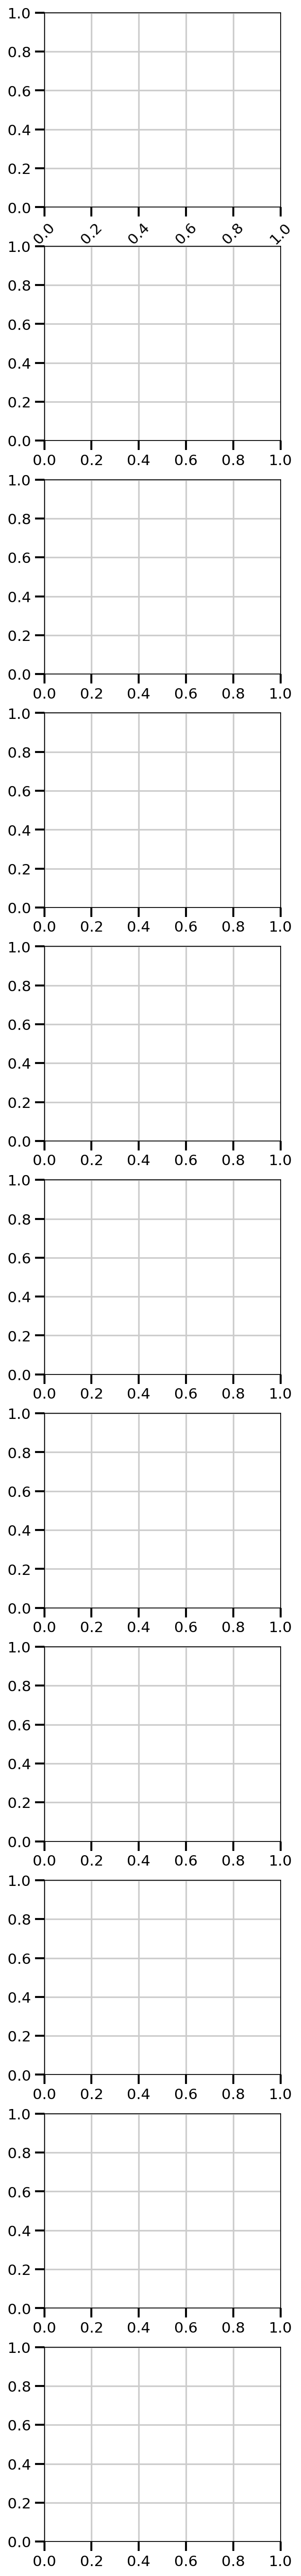

In [57]:
mean_df = df.groupby("model_name").mean()

columns = ["gcd",
           "mlnmi",
           "cad",
           "arclisi",
           "germse",
           "cca",
           "ari",
           "clisi",
           "nmi",
           "asw",
           "isolated_labels_asw"]

fig, axs = plt.subplots(len(columns), 1, figsize=(4, 4*len(columns)))

# Plot each column in a separate subplot
for ax, col in zip(axs, columns):
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, rotation=45)
    sns.barplot(data=mean_df, x=mean_df.index, y=col, ax=ax)
plt.suptitle("Method Benchmarking Metrics")
plt.subplots_adjust(hspace=0.7, top=0.97)
plt.show()

In [ ]:
fig, axs = plt.subplots(len(columns), 1, figsize=(4, 4*len(columns)))

# Plot each column in a separate subplot
for ax, col in zip(axs, columns):
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, rotation=45)
    sns.barplot(data=mean_df, x=mean_df.index, y=col, ax=ax)
plt.suptitle("Method Benchmarking Metrics")
plt.subplots_adjust(hspace=0.7, top=0.97)
plt.show()

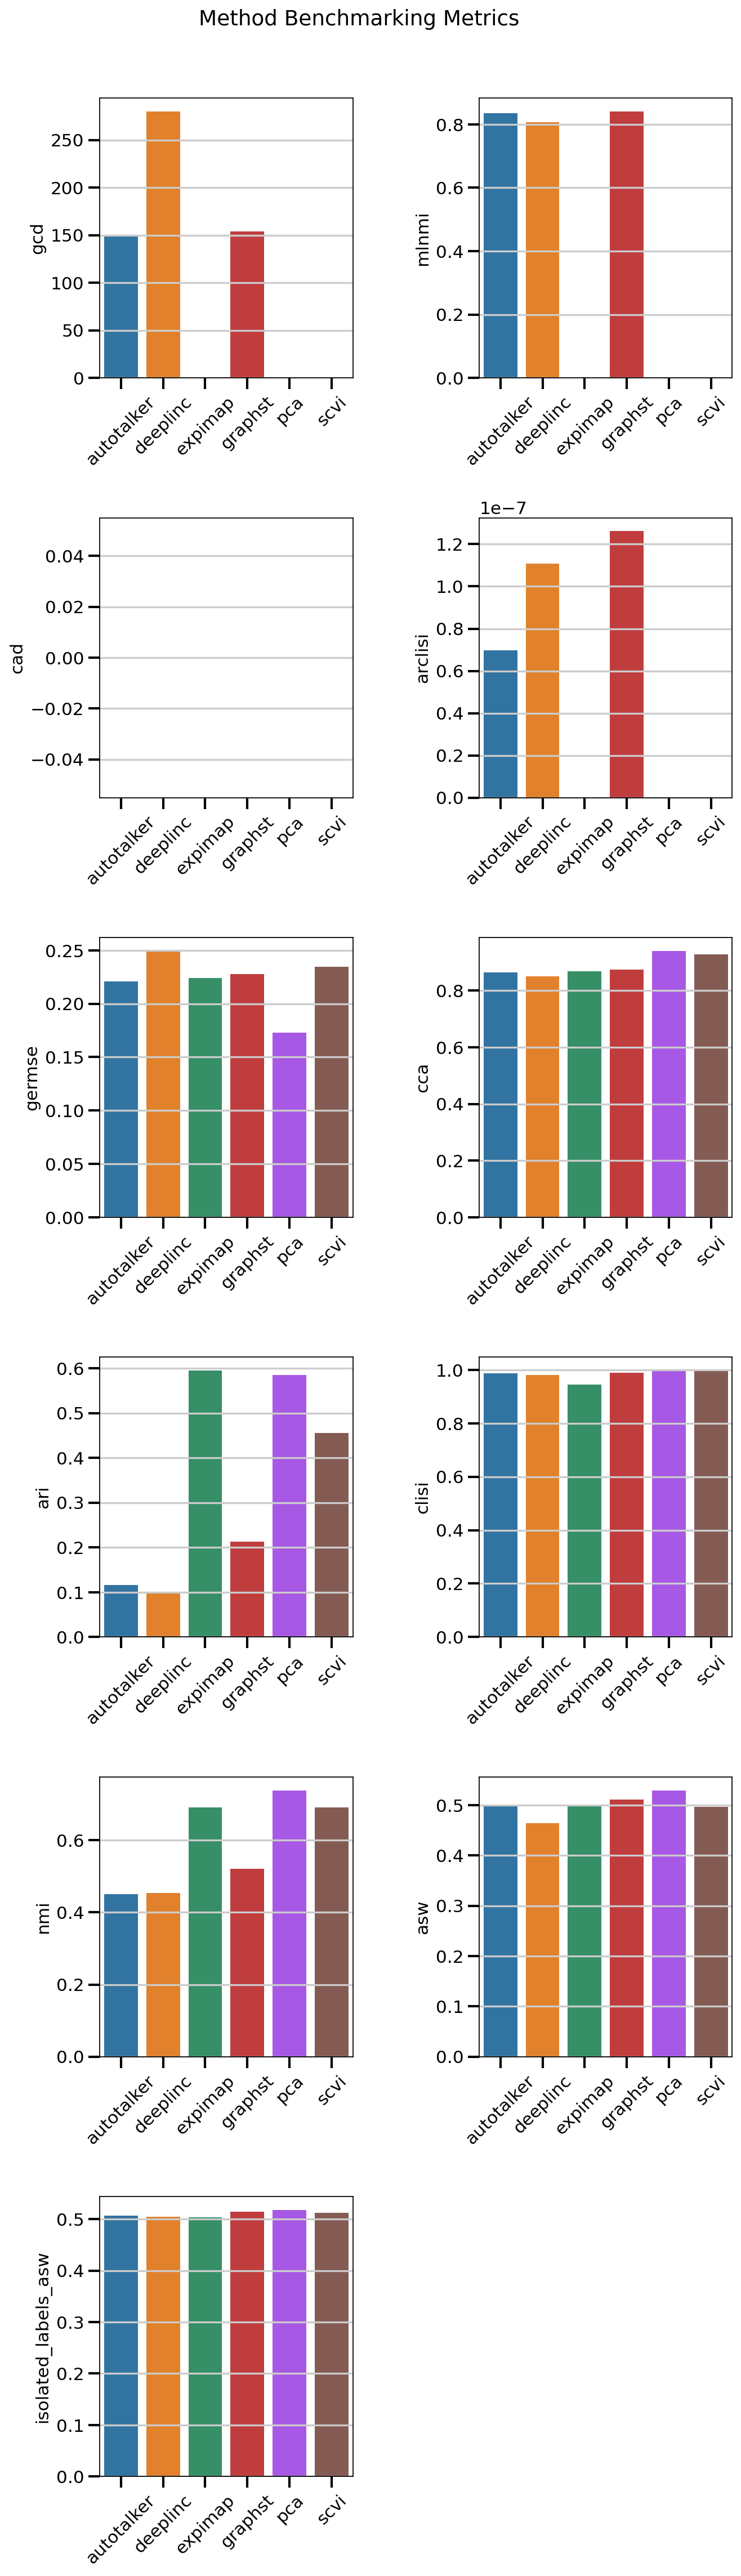

In [78]:

# Create a grid of subplots
fig, axs = plt.subplots(nrows=int(np.ceil(len(columns)/2)), ncols=2, figsize=(9, 3*len(columns)))
axs=axs.flatten()

# Iterate over the columns of the DataFrame
for i, col in enumerate(columns):
    sns.barplot(data=mean_df, x=mean_df.index, y=col, ax=axs[i])
    # Remove the x-axis title
    axs[i].set_xlabel('')
    xlabels = axs[i].get_xticks()
    axs[i].set_xticklabels(mean_df.index, rotation=45)
plt.suptitle("Method Benchmarking Metrics")
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.95)

if len(columns) % 2 != 0:
    fig.delaxes(axs[-1])

plt.show()

In [43]:
benchmarking_dict_list

[{'germse': 0.1727322,
  'cca': 0.9402890377158971,
  'ari': 0.5851471810284834,
  'clisi': 0.997535713251531,
  'nmi': 0.7385439836334322,
  'asw': 0.5294713564217091,
  'isolated_labels_asw': 0.5180858748246228,
  'model_name': 'pca',
  'run': 1},
 {'germse': 0.23464109,
  'cca': 0.9285160380683821,
  'ari': 0.4552368648449847,
  'clisi': 0.9960778162319379,
  'nmi': 0.6907614873560975,
  'asw': 0.4961041526403278,
  'isolated_labels_asw': 0.5128257985570994,
  'model_name': 'scvi',
  'run': 1},
 {'germse': 0.22424112,
  'cca': 0.8680296087416285,
  'ari': 0.5950722457653652,
  'clisi': 0.9447290507727537,
  'nmi': 0.6904399328566299,
  'asw': 0.49962300920742564,
  'isolated_labels_asw': 0.5032303386479211,
  'model_name': 'expimap',
  'run': 1},
 {'gcd': 280.12140225266614,
  'mlnmi': 0.8068906142247841,
  'cad': nan,
  'arclisi': 1.1084581577782275e-07,
  'germse': 0.24954142,
  'cca': 0.8503348607684174,
  'ari': 0.10036202939404279,
  'clisi': 0.9802992501288682,
  'nmi': 0.4535

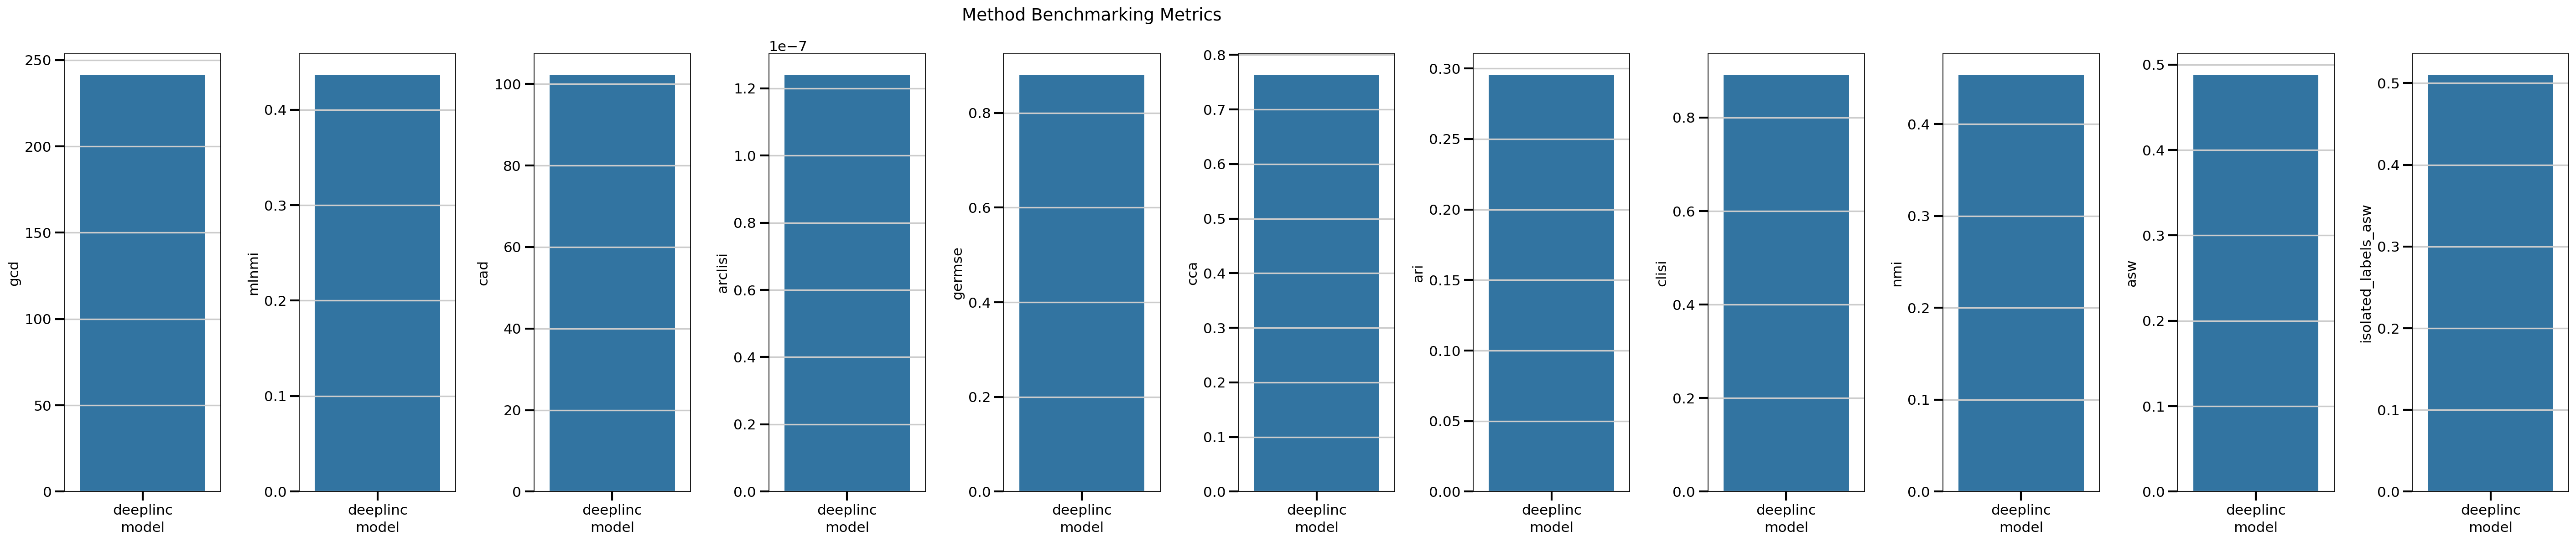